# Model Performance Analysis

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import json
import seaborn as sns

## Load Rollouts from json

In [31]:
rollout_path = "../assets/rollouts/"
rollout_files = glob.glob(os.path.join(rollout_path, "rollout_results_*.json"))

# Load all rollout files
results = {}
for file in rollout_files:
    with open(file, "r") as f:
        # Get the filename without the path and extension e.g "merged_task_1_lora"
        filename = os.path.basename(file)
        filename = filename.split(".")[0]
        filename = "_".join(filename.split("_")[2:])
        # Load the json file
        rollout = json.load(f)
        results[filename] = rollout

print(sorted(results.keys()))


['merged30k_task1_fpft', 'merged30k_task1_lora', 'merged30k_task2_fpft', 'merged30k_task2_lora', 'merged30k_task3_fpft', 'merged30k_task3_lora', 'merged30k_task4_fpft', 'merged30k_task4_lora', 'merged60k_task1_fpft', 'merged60k_task1_lora', 'merged60k_task2_fpft', 'merged60k_task2_lora', 'merged60k_task3_fpft', 'merged60k_task3_lora', 'merged60k_task4_fpft', 'merged60k_task4_lora', 'task1_fpft', 'task1_lora', 'task2_fpft', 'task2_lora', 'task3_fpft', 'task3_lora', 'task4_fpft', 'task4_lora']


## Combine all results into a single DataFrame

----

In [ ]:
df = pd.DataFrame(columns=["merged", "task", "lora", "success_rate", "avg_task_progress", "grad_steps", "avg_duration"])
for filename, rollout in results.items():
    # Split filename into merged (bool), task (int), lora (bool)
    merged = "merged" in filename
    if merged:
        task = int(filename.split("_")[1][-1])
    else:
        task = int(filename.split("_")[0][-1])
    lora = "lora" in filename
    if "30k" in filename:
        grad_steps = 30_000
    elif "60k" in filename:
        grad_steps = 60_000
    else:
        grad_steps = 20_000

    # Create a temp DataFrame from the rollout
    temp = pd.DataFrame(rollout)
    # Recalculate the score
    for i in range(len(temp)):
        temp.loc[i, "score"] = temp.loc[i, "steps_completed"] / temp.loc[i, "total_steps"]
    # Calculate the success rate
    success_rate = temp["success"].mean()
    # Calculate the avg task progress
    avg_task_progress = temp["score"].mean()
    avg_duration = temp["duration"].mean()
    # Add the results to the main DataFrame
    df.loc[filename] = [merged, task, lora, success_rate, avg_task_progress, grad_steps, avg_duration]

df

       timestamp  success   duration  steps_completed  total_steps     score
0   1.765463e+09    False  14.576691                2            3  0.666667
1   1.765463e+09    False  21.090429                2            3  0.666667
2   1.765463e+09    False  36.924832                2            3  0.666667
3   1.765464e+09     True  22.187122                3            3  1.000000
4   1.765525e+09     True  20.214878                3            3  1.000000
5   1.765525e+09     True  26.681844                3            3  1.000000
6   1.765525e+09     True  22.647744                3            3  1.000000
7   1.765526e+09    False  70.796598                0            3  0.000000
8   1.765526e+09    False  23.634407                2            3  0.666667
9   1.765526e+09     True  21.175344                3            3  1.000000
10  1.765526e+09     True  21.178683                3            3  1.000000
11  1.765526e+09     True  30.541094                3            3  1.000000

,merged,task,lora,success_rate,avg_task_progress,grad_steps,avg_duration
task4_fpft,False,4,False,0.70,0.866667,20000,24.787649
merged60k_task3_lora,True,3,True,0.70,0.700000,60000,20.576684
merged60k_task4_fpft,True,4,False,0.80,0.866667,60000,28.561584
merged30k_task3_lora,True,3,True,0.85,0.850000,30000,27.455724
merged30k_task1_fpft,True,1,False,0.50,0.800000,30000,22.265568
merged30k_task4_lora,True,4,True,0.55,0.750000,30000,32.522494
task1_lora,False,1,True,0.45,0.816667,20000,19.055551
merged60k_task2_fpft,True,2,False,0.25,0.687500,60000,26.827389
merged30k_task4_fpft,True,4,False,0.80,0.933333,30000,27.103511
task3_fpft,False,3,False,0.90,0.925000,20000,22.307488


In [ ]:
# order df by task and avg_task_progress 
df = df.sort_values(by=["task", "avg_task_progress"], ascending=False)
df

,merged,task,lora,success_rate,avg_task_progress,grad_steps
merged30k_task4_fpft,True,4,False,0.80,0.933333,30000
task4_lora,False,4,True,0.80,0.900000,20000
task4_fpft,False,4,False,0.70,0.866667,20000
merged60k_task4_fpft,True,4,False,0.80,0.866667,60000
merged30k_task4_lora,True,4,True,0.55,0.750000,30000
merged60k_task4_lora,True,4,True,0.50,0.700000,60000
task3_fpft,False,3,False,0.90,0.925000,20000
merged60k_task3_fpft,True,3,False,0.90,0.925000,60000
merged30k_task3_lora,True,3,True,0.85,0.850000,30000
task3_lora,False,3,True,0.85,0.850000,20000


*For the merged models, 60k grad_steps is the best for full-fine tuning and 30k grad_steps is the best for LoRA.*

*-> Remove the other entries for now.*

In [ ]:
filter = (df["merged"] == False) | ((df["merged"] == True) & (((df["lora"] == False) & (df["grad_steps"] == 60_000)) | ((df["lora"] == True) & (df["grad_steps"] == 30_000))))
df = df[filter].copy()
df

,merged,task,lora,success_rate,avg_task_progress,grad_steps
task4_lora,False,4,True,0.80,0.900000,20000
task4_fpft,False,4,False,0.70,0.866667,20000
merged60k_task4_fpft,True,4,False,0.80,0.866667,60000
merged30k_task4_lora,True,4,True,0.55,0.750000,30000
task3_fpft,False,3,False,0.90,0.925000,20000
merged60k_task3_fpft,True,3,False,0.90,0.925000,60000
merged30k_task3_lora,True,3,True,0.85,0.850000,30000
task3_lora,False,3,True,0.85,0.850000,20000
merged60k_task2_fpft,True,2,False,0.25,0.687500,60000
task2_fpft,False,2,False,0.35,0.675000,20000


## Analyse specific Subsets

### Group by grad_steps

In [ ]:
avg_success_rate = df.groupby("grad_steps").success_rate.mean()
print(f"Avg Success Rate for 20k Grad Steps: {avg_success_rate[20000]:.2f}")
print(f"Avg Success Rate for 30k Grad Steps: {avg_success_rate[30000]:.2f}")
print(f"Avg Success Rate for 60k Grad Steps: {avg_success_rate[60000]:.2f}")

avg_task_progress = df.groupby("grad_steps").avg_task_progress.mean()
print()
print(f"Avg Task Progress for 20k Grad Steps: {avg_task_progress[20000]:.2f}")
print(f"Avg Task Progress for 30k Grad Steps: {avg_task_progress[30000]:.2f}")
print(f"Avg Task Progress for 60k Grad Steps: {avg_task_progress[60000]:.2f}")


Avg Success Rate for 20k Grad Steps: 0.61
Avg Success Rate for 30k Grad Steps: 0.53
Avg Success Rate for 60k Grad Steps: 0.65

Avg Task Progress for 20k Grad Steps: 0.82
Avg Task Progress for 30k Grad Steps: 0.73
Avg Task Progress for 60k Grad Steps: 0.84


### Group by merged

In [ ]:
avg_success_rate = df.groupby("merged").success_rate.mean()
print(f"Avg Success Rate for Merged Models: {avg_success_rate[True]:.2f}")
print(f"Avg Success Rate for Dedicated Models: {avg_success_rate[False]:.2f}")

avg_task_progress = df.groupby("merged").avg_task_progress.mean()
print()
print(f"Avg Task Progress for Merged Models: {avg_task_progress[True]:.2f}")
print(f"Avg Task Progress for Dedicated Models: {avg_task_progress[False]:.2f}")


Avg Success Rate for Merged Models: 0.59
Avg Success Rate for Dedicated Models: 0.61

Avg Task Progress for Merged Models: 0.79
Avg Task Progress for Dedicated Models: 0.82


### Group by LoRA

In [ ]:
avg_success_rate = df.groupby("lora").success_rate.mean()
print(f"Avg Success Rate for LoRA Models: {avg_success_rate[True]:.2f}")
print(f"Avg Success Rate for Non-LoRA Models: {avg_success_rate[False]:.2f}")

avg_task_progress = df.groupby("lora").avg_task_progress.mean()
print()
print(f"Avg Task Progress for LoRA Models: {avg_task_progress[True]:.2f}")
print(f"Avg Task Progress for Non-LoRA Models: {avg_task_progress[False]:.2f}")

Avg Success Rate for LoRA Models: 0.53
Avg Success Rate for Non-LoRA Models: 0.66

Avg Task Progress for LoRA Models: 0.76
Avg Task Progress for Non-LoRA Models: 0.84


### Group by task

In [ ]:
avg_success_rate = df.groupby("task").success_rate.mean()
for i in range(1, len(avg_success_rate) + 1):
    print(f"Avg Success Rate for Task {i}: {avg_success_rate[i]:.2f}")

avg_task_progress = df.groupby("task").avg_task_progress.mean()
print()
for i in range(1, len(avg_task_progress) + 1):
    print(f"Avg Task Progress for Task {i}: {avg_task_progress[i]:.2f}")


Avg Success Rate for Task 1: 0.59
Avg Success Rate for Task 2: 0.21
Avg Success Rate for Task 3: 0.88
Avg Success Rate for Task 4: 0.71

Avg Task Progress for Task 1: 0.85
Avg Task Progress for Task 2: 0.62
Avg Task Progress for Task 3: 0.89
Avg Task Progress for Task 4: 0.85


### Group by LoRA and merged

In [ ]:
avg_success_rate = df.groupby(["lora", "merged"]).success_rate.mean()
print(avg_success_rate)

avg_task_progress = df.groupby(["lora", "merged"]).avg_task_progress.mean()
print()
print(avg_task_progress)


lora   merged
False  False     0.6750
       True      0.6500
True   False     0.5375
       True      0.5250
Name: success_rate, dtype: float64

lora   merged
False  False     0.845833
       True      0.840625
True   False     0.785417
       True      0.734375
Name: avg_task_progress, dtype: float64


### Group by task and merged

In [ ]:
avg_success_rate = df.groupby(["task", "merged"]).success_rate.mean()
print(avg_success_rate)

avg_task_progress = df.groupby(["task", "merged"]).avg_task_progress.mean()
print()
print(avg_task_progress)

task  merged
1     False     0.600
      True      0.575
2     False     0.200
      True      0.225
3     False     0.875
      True      0.875
4     False     0.750
      True      0.675
Name: success_rate, dtype: float64

task  merged
1     False     0.866667
      True      0.841667
2     False     0.625000
      True      0.612500
3     False     0.887500
      True      0.887500
4     False     0.883333
      True      0.808333
Name: avg_task_progress, dtype: float64


## Plots

---

We are trying to answer the following questions:

1. How much better is full fine-tuning than LoRA?
2. How does the difference change over the different tasks?


Question 1

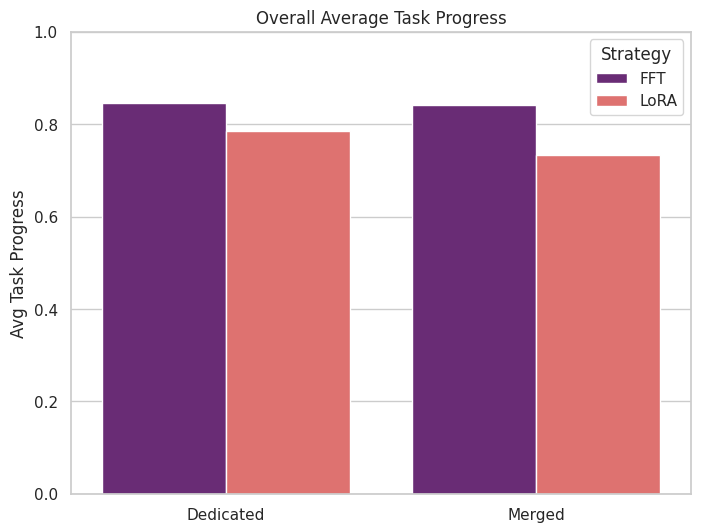

In [ ]:
plt.figure(figsize=(8, 6))
# We group by the broad categories for a high-level view
summary_df = df.groupby(['lora', 'merged'])['avg_task_progress'].mean().reset_index()
summary_df['Strategy'] = summary_df.apply(lambda x: 
    f"{'LoRA' if x['lora'] else 'FFT'}", axis=1)
summary_df['Type'] = summary_df.apply(lambda x: 
    f"{'Merged' if x['merged'] else 'Dedicated'}", axis=1)

sns.barplot(data=summary_df, x="Type", y="avg_task_progress", hue="Strategy", palette="magma")
plt.title("Overall Average Task Progress")
plt.xlabel("") # Remove x label
plt.ylabel("Avg Task Progress")
plt.ylim(0, 1.0)
plt.show()

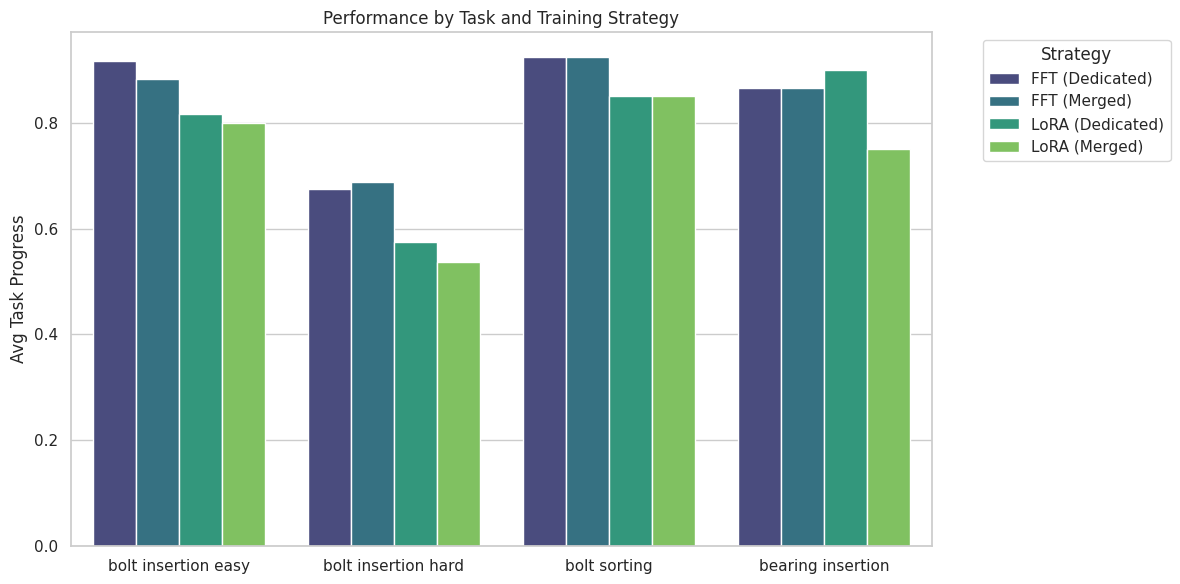

In [ ]:
sns.set_theme(style="whitegrid")
plt.rcParams.update({'font.size': 12})

# 1. THE MAIN COMPARISON: Success Rate per Task
# This answers: "Which model is best for which task?"
plt.figure(figsize=(12, 6))
# Create a custom 'Method' column for cleaner legends
df['Method'] = df.apply(lambda x: 
    f"{'LoRA' if x['lora'] else 'FFT'} ({'Merged' if x['merged'] else 'Dedicated'})", axis=1)

task_stings = {
    1: "bolt insertion easy",
    2: "bolt insertion hard",
    3: "bolt sorting",
    4: "bearing insertion"
}

df['task_str'] = df['task'].apply(lambda x: task_stings[x])

sns.barplot(
    data=df.sort_values(by="task"),
    x="task_str", 
    y="avg_task_progress", 
    hue="Method",
    palette="viridis"
)
plt.title("Performance by Task and Training Strategy")
plt.ylabel("Avg Task Progress")
plt.xlabel("")
plt.legend(title="Strategy", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

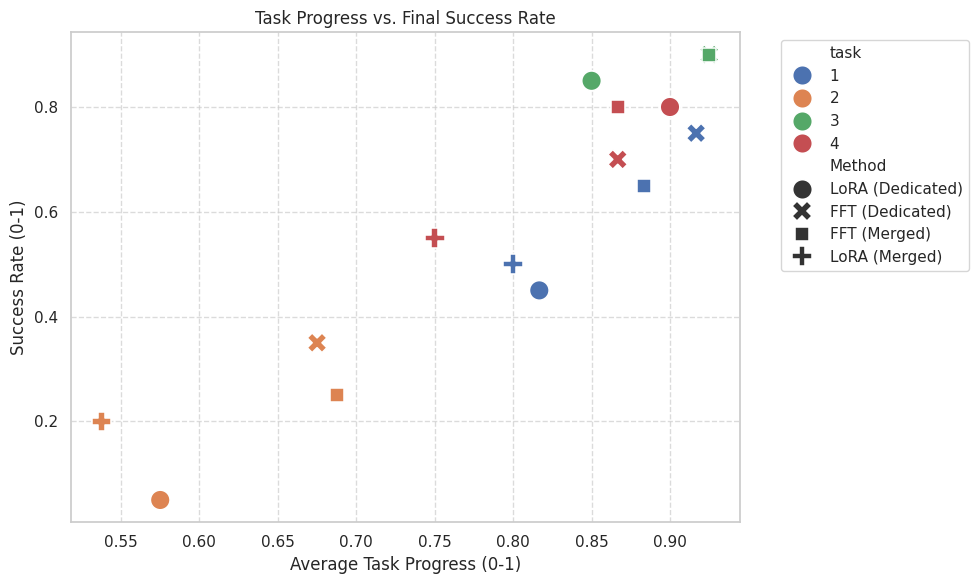

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df, 
    x="avg_task_progress", 
    y="success_rate", 
    hue="task", 
    style="Method", 
    s=200, # Marker size
    palette="deep"
)
plt.title("Task Progress vs. Final Success Rate")
plt.xlabel("Average Task Progress (0-1)")
plt.ylabel("Success Rate (0-1)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

    lora  merged  avg_duration Strategy       Type
0  False   False     22.952837      FFT  Dedicated
1  False    True     23.099595      FFT     Merged
2   True   False     21.873917     LoRA  Dedicated
3   True    True     24.119057     LoRA     Merged


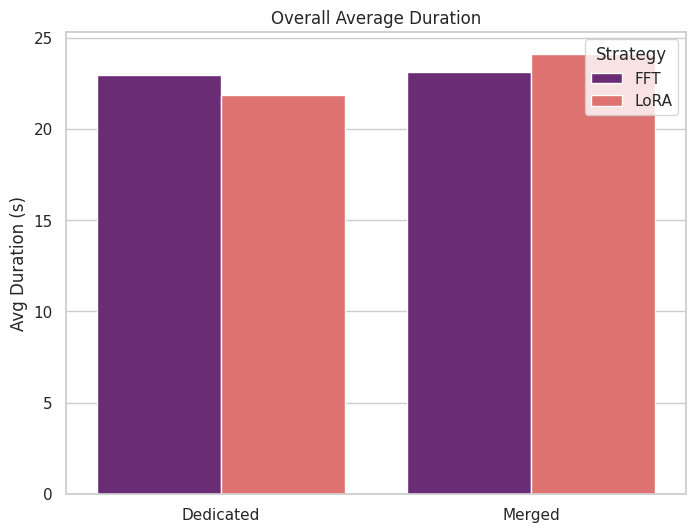

In [38]:
plt.figure(figsize=(8, 6))
# We group by the broad categories for a high-level view
summary_df = df.groupby(['lora', 'merged'])['avg_duration'].mean().reset_index()
summary_df['Strategy'] = summary_df.apply(lambda x: 
    f"{'LoRA' if x['lora'] else 'FFT'}", axis=1)
summary_df['Type'] = summary_df.apply(lambda x: 
    f"{'Merged' if x['merged'] else 'Dedicated'}", axis=1)

print(summary_df)

sns.barplot(data=summary_df, x="Type", y="avg_duration", hue="Strategy", palette="magma")
plt.title("Overall Average Duration")
plt.xlabel("") # Remove x label
plt.ylabel("Avg Duration (s)")
plt.show()

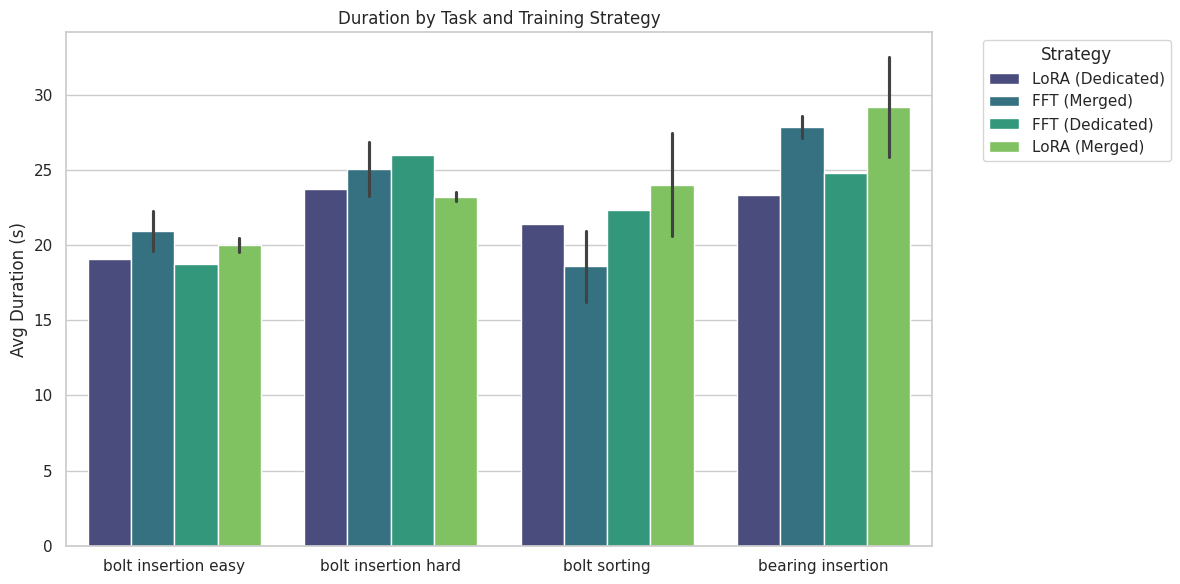

In [35]:
sns.set_theme(style="whitegrid")
plt.rcParams.update({'font.size': 12})

# 1. THE MAIN COMPARISON: Success Rate per Task
# This answers: "Which model is best for which task?"
plt.figure(figsize=(12, 6))
# Create a custom 'Method' column for cleaner legends
df['Method'] = df.apply(lambda x: 
    f"{'LoRA' if x['lora'] else 'FFT'} ({'Merged' if x['merged'] else 'Dedicated'})", axis=1)

task_stings = {
    1: "bolt insertion easy",
    2: "bolt insertion hard",
    3: "bolt sorting",
    4: "bearing insertion"
}

df['task_str'] = df['task'].apply(lambda x: task_stings[x])

sns.barplot(
    data=df.sort_values(by="task"),
    x="task_str", 
    y="avg_duration", 
    hue="Method",
    palette="viridis"
)
plt.title("Duration by Task and Training Strategy")
plt.ylabel("Avg Duration (s)")
plt.xlabel("")
plt.legend(title="Strategy", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()